### Data Source
All NHL shot and play-by-play data provided by [MoneyPuck.com](https://moneypuck.com/).  
Used under their open data policy.  


In [34]:
# import block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from scipy.stats import gaussian_kde
# Show plots in notebook
%matplotlib inline

In [35]:
# load data
url = "https://peter-tanner.com/moneypuck/downloads/shots_2024.zip"
df = pd.read_csv(url)

Baseline Logistic Regression- from HockeyLogR_basic.ipynb

In [36]:
# features and target
features = ['xCordAdjusted','yCordAdjusted','shotAngleAdjusted','shotType','shotDistance','shotRebound','shotRush']
target = 'goal'

In [37]:
# model dataframe
df_model = df[features + [target,'xGoal']].dropna().copy()

In [38]:
# train test split
X = df_model.drop(columns=[target,'xGoal'])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# one categorical column
# Identify categorical columns
categorical_cols = ['shotType']  # add others if needed

# One-hot encode
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure both train and test have same columns
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

In [40]:
# baseline model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_enc,y_train)
y_prob = model.predict_proba(X_test_enc)[:, 1]

baseline_auc = roc_auc_score(y_test, y_prob)
baseline_brier = brier_score_loss(y_test, y_prob)

print(f"Baseline AUC: {baseline_auc:.3f}, Brier: {baseline_brier:.3f}")

Baseline AUC: 0.724, Brier: 0.062


In [41]:
# create some features

#game situtation: 5v5, 5v4, 4v4, etc
df['situation'] = df['homeSkatersOnIce'].astype(str) + "v" + df['awaySkatersOnIce'].astype(str)

# Create score differential from shooter's perspective
df['scoreDifferential'] = np.where(
    df['isHomeTeam'] == 1,   # condition
    df['homeTeamGoals'] - df['awayTeamGoals'],  # if shooter is home team
    df['awayTeamGoals'] - df['homeTeamGoals']   # if shooter is away team
)

In [42]:
# candidate groups, experiment and check names
candidate_groups = {
    "Game context": ['period', 'scoreDifferential','time','timeSinceFaceoff'],
    "Shooter info": ['shooterLeftRight','shooterTimeOnIce','playerPositionThatDidEvent'],
    "Team context": ['shootingTeamAverageTimeOnIce','defendingTeamAverageTimeOnIce'],
    #"Goalie context": ['goalieIdForShot'],
    "Situation": ['situation','offWing','timeDifferenceSinceChange','averageRestDifference','shotOnEmptyNet'],  # PP/EV/SH encoded
    "Control":['homeTeamWon','isPlayoffGame'],
}

for group_name, cols in candidate_groups.items():
    print(f"\n{group_name}:")
    print(df[cols].dtypes)


Game context:
period               int64
scoreDifferential    int64
time                 int64
timeSinceFaceoff     int64
dtype: object

Shooter info:
shooterLeftRight              object
shooterTimeOnIce               int64
playerPositionThatDidEvent    object
dtype: object

Team context:
shootingTeamAverageTimeOnIce     float64
defendingTeamAverageTimeOnIce    float64
dtype: object

Situation:
situation                     object
offWing                        int64
timeDifferenceSinceChange      int64
averageRestDifference        float64
shotOnEmptyNet                 int64
dtype: object

Control:
homeTeamWon      int64
isPlayoffGame    int64
dtype: object


In [43]:
# loop through candidates and store results/check for improvements
results = []

for group_name, group_features in candidate_groups.items():

    # --- 1. Build the temporary dataset for this iteration ---
    features_this_iter = features + group_features  # baseline + current group
    all_features = list(set(features_this_iter + [target, 'xGoal']))
    df_iter = df[all_features].dropna().copy()  # drop NAs fresh for each iteration

    # --- 2. Train/test split ---
    X = df_iter.drop(columns=[target, 'xGoal'])
    y = df_iter[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # --- 3. One-hot encode categoricals ---
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

    # Align columns
    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

    # --- 4. Fit logistic regression ---
    model = LogisticRegression(max_iter=5000)
    model.fit(X_train_enc, y_train)

    # --- 5. Compute metrics ---
    y_prob = model.predict_proba(X_test_enc)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    brier = brier_score_loss(y_test, y_prob)

    results.append({
        "group": group_name,
        "features": group_features,
        "AUC": auc,
        "Brier": brier
    })

# --- 6. Convert results to DataFrame ---
results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print(results_df)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          group                                           features       AUC  \
3     Situation  [situation, offWing, timeDifferenceSinceChange...  0.763308   
1  Shooter info  [shooterLeftRight, shooterTimeOnIce, playerPos...  0.745635   
2  Team context  [shootingTeamAverageTimeOnIce, defendingTeamAv...  0.734217   
0  Game context  [period, scoreDifferential, time, timeSinceFac...  0.725582   
4       Control                       [homeTeamWon, isPlayoffGame]  0.725045   

      Brier  
3  0.060480  
1  0.061185  
2  0.061798  
0  0.062032  
4  0.062002  


In [44]:
# Combined model with best groups
selected_groups = ['Situation', 'Shooter info', 'Team context']

# Concatenate all features from those groups into a single list
combined_features = sum([candidate_groups[g] for g in selected_groups], [])

# If you want to include your baseline features as well:
all_features_for_model = features + combined_features

df_combined = df[all_features_for_model + [target, 'xGoal']].dropna().copy()

In [47]:
# train/test split combined model
X = df_combined.drop(columns=[target, 'xGoal'])
y = df_combined[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

In [48]:
# combined model
model = LogisticRegression(max_iter=5000)
model.fit(X_train_enc,y_train)
y_prob = model.predict_proba(X_test_enc)[:, 1]

combined_auc = roc_auc_score(y_test, y_prob)
combined_brier = brier_score_loss(y_test, y_prob)

print(f"Combined AUC: {combined_auc:.3f}, Brier: {combined_brier:.3f}")

Combined AUC: 0.773, Brier: 0.060


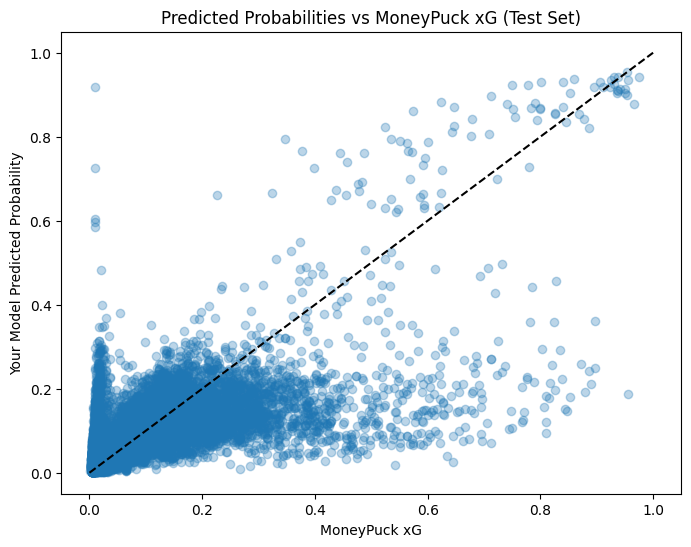

In [50]:
# compare to MoneyPuck's xGoal model
# Get the corresponding xGoal values for the test set
xgoal_test = df_combined.loc[X_test_enc.index, 'xGoal']

# Now plot
plt.figure(figsize=(8,6))
plt.scatter(xgoal_test, y_prob, alpha=0.3)
plt.plot([0,1], [0,1], 'k--')  # diagonal reference
plt.xlabel("MoneyPuck xG")
plt.ylabel("Your Model Predicted Probability")
plt.title("Predicted Probabilities vs MoneyPuck xG (Test Set)")
plt.show()

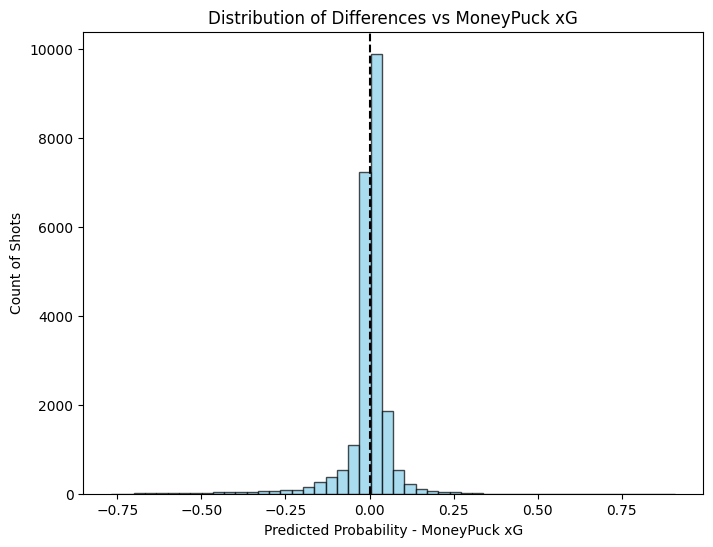

In [51]:
# plot absolute difference vs MoneyPuck
diff = y_prob - xgoal_test
abs_diff = np.abs(diff)

plt.figure(figsize=(8,6))
plt.hist(diff, bins=50, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Predicted Probability - MoneyPuck xG")
plt.ylabel("Count of Shots")
plt.title("Distribution of Differences vs MoneyPuck xG")
plt.show()